In [45]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt


# Process the Exhibit Data

In [46]:
# Load Exhibit Information
exhibit = pd.read_csv("Exhibit Based Template - V2_AAM_last_three_years.csv")
exhibit.drop(["ExhibitionCode","exhibit name ","Exhibit Full Name","Exhibit Short name", \
"General Attendance","Daily General Attendance","Uptake rate","SE Attendance", \
"Construction Period Flag","Market budget","Number of other exhibits"], axis = 1, inplace= True)

In [47]:
exhibit.columns

Index(['start date', 'end date', 'duration', 'country', 'region', 'medium',
       'material exclusitivity', 'size', 'space', 'exclusivity', 'Stories',
       'Timeline type', 'topic popularity', 'artists popularity',
       'Exhibit Prioritized Ranking', 'Market Budget Flag'],
      dtype='object')

In [48]:
exhibit["size"].unique()

array(['small', 'medium', 'large'], dtype=object)

In [49]:
# Transform category to scale
def category_to_scale(x):
    if x == "small": x = 1
    elif x == "Low": x = 1
    elif x == "medium": x = 2
    elif x == "Medium": x = 2
    elif x == "large": x = 3
    elif x == "High": x = 3
    return x

In [50]:
exhibit["size"] = exhibit["size"].apply(category_to_scale)
exhibit["space"] = exhibit["space"].apply(category_to_scale)
exhibit["Market Budget Flag"] = exhibit["Market Budget Flag"].apply(category_to_scale)

In [51]:
# Merge medium column
exhibit["medium"].value_counts()
exhibit.loc[~exhibit["medium"].isin(["paintings","various","video","lacquerware"]),"medium"] = "other"

In [52]:
def str_to_datetime(x):
    x_dt = dt.strptime(x, '%Y/%m/%d')
    return x_dt

In [53]:
exhibit["start date"] = exhibit["start date"].apply(str_to_datetime)
exhibit["end date"] = exhibit["end date"].apply(str_to_datetime)

In [54]:
# exhibit.head(1)

# Transform to Daily level

In [55]:
exhibit_dummy = pd.get_dummies(data = exhibit, columns=['country', 'region','medium','Timeline type'])


## Add columns to daily level dataset

In [56]:
# exhibit_dummy.head(1)

In [57]:
# Load daily attendance
daily_attendance = pd.read_excel("estimated daily attendance.xlsx",sheet_name="Running Total")
daily_attendance = daily_attendance.iloc[:,:4]

In [58]:
daily_attendance.head(1)

,Date,Total Attendance,Weekday,Free Sunday
0,2016-07-01,545,Friday,0


### Find the Free Sunday (First Sunday for each month)

In [59]:
already_free_sunday = 0
current_month = daily_attendance["Date"][0].month
for i in range(len(daily_attendance)):
    if daily_attendance["Date"][i].month != current_month:
        already_free_sunday = 0
        current_month = daily_attendance["Date"][i].month
    if already_free_sunday == 0:
        if daily_attendance["Weekday"][i] == "Sunday":
            already_free_sunday = 1
            daily_attendance["Free Sunday"][i] = 1

    

/Users/lush/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [60]:
daily_attendance["Free Sunday"].value_counts()

0    924
1     32
Name: Free Sunday, dtype: int64

In [61]:
# Check whether the Free Sunday is correct
# daily_attendance[daily_attendance["Free Sunday"]==1].tail(10)

In [62]:
# Get the columns that needed to add into the daily-level dataset
count_columns = [i for i in exhibit_dummy.columns if i.startswith(("country","region_","medium_","Timeline"))]

aggregate_columns = [i for i in exhibit_dummy.columns if not i.startswith(("country","region_","medium_","Timeline")) ]
aggregate_columns = aggregate_columns[3:]


In [63]:
# Add Count columns into daily-level dataset
for column_name in count_columns:
    daily_attendance.insert(len(daily_attendance.columns),column_name,0)
    

In [64]:
# Add Aggregate columns into daily-level dataset
for column_name in aggregate_columns:
    tmp = column_name
    tmp = "avg_" + tmp
    daily_attendance.insert(len(daily_attendance.columns),tmp,0)
    tmp = column_name
    tmp = "max_" + tmp
    daily_attendance.insert(len(daily_attendance.columns),tmp,0)
    tmp = column_name
    tmp = "min_" + tmp
    daily_attendance.insert(len(daily_attendance.columns),tmp,0)

In [65]:
# Define a function to transform int to float
def int_to_float(x):
    x = float(x)
    return x

In [66]:
# Transform column type to float
for column in [i for i in daily_attendance.columns if i not in ["Date","Weekday"]]:
    daily_attendance[column] = daily_attendance[column].astype(float)

In [67]:
# daily_attendance.head(1)

In [68]:
# exhibit_dummy.columns

In [69]:
# daily_attendance.head(1)

In [70]:
for day_index in range(len(daily_attendance)):
    # Create aggregated columns list
    size_list = [0]
    material_exclusitivity_list = [0]
    space_list = [0]
    exclusivity_list = [0]
    Stories_list = [0]
    topic_popularity_list = [0]
    artists_popularity_list  = [0]
    Exhibit_Prioritized_Ranking_list = [0]
    Market_Budget_Flag_list = [0]
    
    # Create aggregated columns dictionary
    column_dict = {"size_list":size_list, "material_exclusitivity_list":material_exclusitivity_list,"space_list":space_list \
                  ,"exclusivity_list":exclusivity_list,"Stories_list":Stories_list, "topic_popularity_list":topic_popularity_list \
                  ,"artists_popularity_list":artists_popularity_list, "Exhibit_Prioritized_Ranking_list":Exhibit_Prioritized_Ranking_list \
                  ,"Market_Budget_Flag_list":Market_Budget_Flag_list}

    for exhibit_index in range(len(exhibit_dummy)):
        if exhibit_dummy["start date"][exhibit_index] <= daily_attendance["Date"][day_index] and exhibit_dummy["end date"][exhibit_index] >= daily_attendance["Date"][day_index]:
            # Add aggregated columns to list
            size_list.append(exhibit_dummy["size"][exhibit_index])
            material_exclusitivity_list.append(exhibit_dummy["material exclusitivity"][exhibit_index])
            space_list.append(exhibit_dummy["space"][exhibit_index])
            exclusivity_list.append(exhibit_dummy["exclusivity"][exhibit_index])
            Stories_list.append(exhibit_dummy["Stories"][exhibit_index])
            topic_popularity_list.append(exhibit_dummy["topic popularity"][exhibit_index])
            artists_popularity_list.append(exhibit_dummy["artists popularity"][exhibit_index])
            Exhibit_Prioritized_Ranking_list.append(exhibit_dummy["Exhibit Prioritized Ranking"][exhibit_index])
            Market_Budget_Flag_list.append(exhibit_dummy["Market Budget Flag"][exhibit_index])
            # Add count columns to daily-level dataset
            for count_column in count_columns:
                daily_attendance[count_column][day_index] += exhibit_dummy[count_column][exhibit_index]
    
    # Add aggregate columns to daily-level dataset
    for aggregate_column in aggregate_columns:
        column_list_name = aggregate_column.replace(" ","_") +"_list"
        tmp_list = column_dict[column_list_name]
        tmp_avg_column_name = "avg_" + aggregate_column
        tmp_min_column_name = "min_" + aggregate_column
        tmp_max_column_name = "max_" + aggregate_column
        daily_attendance[tmp_avg_column_name][day_index] = pd.Series(tmp_list).mean()
        daily_attendance[tmp_min_column_name][day_index] = pd.Series(tmp_list).min()
        daily_attendance[tmp_max_column_name][day_index] = pd.Series(tmp_list).max()

        

/Users/lush/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lush/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lush/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lush/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launch

In [71]:
# daily_attendance.describe()

# Feature Engineering

## Get Moving Average for Attendance

In [72]:
# 7 days SMA
SMA_7 = daily_attendance["Total Attendance"].shift(1).rolling(window=7).mean()
# 14 days SMA
SMA_14 = daily_attendance["Total Attendance"].shift(1).rolling(window=14).mean()
# 30 days SMA
SMA_30 = daily_attendance["Total Attendance"].shift(1).rolling(window=30).mean()

# 7 days EMA
EMA_7 = daily_attendance["Total Attendance"].shift(1).ewm(span=10,min_periods=7, adjust=False).mean()
# 14 days EMA
EMA_14 = daily_attendance["Total Attendance"].shift(1).ewm(span=10,min_periods=14, adjust=False).mean()
# 30 days EMA
EMA_30 = daily_attendance["Total Attendance"].shift(1).ewm(span=10,min_periods=30, adjust=False).mean()


In [73]:
# Add Moving Average to Daily-level dataset
daily_attendance["SMA_7"] = SMA_7
daily_attendance["SMA_14"] = SMA_14
daily_attendance["SMA_30"] = SMA_30
daily_attendance["EMA_7"] = EMA_7
daily_attendance["EMA_14"] = EMA_14
daily_attendance["EMA_30"] = EMA_30


In [74]:
# Drop NA rows & Transform column category
daily_attendance.dropna(axis = "index",inplace = True)
daily_attendance.reset_index(inplace = True)
Date = daily_attendance["Date"]
daily_attendance.drop(["index","Date"],axis = 1, inplace = True)
daily_attendance["Weekday"] = daily_attendance["Weekday"].astype("category")

In [75]:
# daily_attendance.head()

In [76]:
# daily_attendance.columns

# Modeling

## Split the dataset

In [77]:
origin_train_set = daily_attendance.iloc[:600,:]
origin_test_set = daily_attendance.iloc[600:,:]

In [78]:
origin_train_x = origin_train_set.loc[:,[i for i in origin_train_set.columns if i not in ["Total Attendance"]]]
origin_train_y = origin_train_set["Total Attendance"]
origin_train_x_dummy = pd.get_dummies(data = origin_train_x, columns =["Weekday"])

In [79]:
origin_test_x = origin_test_set.loc[:,[i for i in origin_test_set.columns if i not in ["Total Attendance"]]]
origin_test_y = origin_test_set["Total Attendance"]
origin_test_x_dummy = pd.get_dummies(data = origin_test_x, columns =["Weekday"])
origin_test_y = origin_test_y.reset_index().drop(['index'],axis=1)

### Time Series Split

In [80]:
from sklearn.model_selection import TimeSeriesSplit

ts_split = TimeSeriesSplit(n_splits=5)
# for train_index, test_index in ts_split.split(origin_train_x):
#     print("train_index", train_index,"\n" "test_index:", test_index)
#     X_train, X_test = origin_train_x.iloc[train_index,:], origin_train_x.iloc[test_index,:]
#     y_train, y_test = origin_train_y.iloc[train_index], origin_train_y.iloc[test_index]

## Simple Linear Regression

In [81]:
from sklearn.linear_model import LinearRegression
lm_model = LinearRegression()
lm_model.fit(origin_train_x_dummy,origin_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [82]:
lm_model.score(origin_test_x_dummy,origin_test_y)

-11.334771183178011

## Random Forest

In [83]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor()
RF_model.fit(origin_train_x_dummy,origin_train_y)
RF_score = RF_model.score(origin_test_x_dummy,origin_test_y)
RF_predict = RF_model.predict(origin_test_x_dummy)

/Users/lush/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [84]:
for i in range(len(Date)):
    Date[i] = str(Date[i].year) + "-" + str(Date[i].month) + "-" + str(Date[i].day)
    Date[i] = str(Date[i])

/Users/lush/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lush/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
# Plot the real daily attendance & predicted value
# plt.figure(figsize = (16,8))
# plt.plot(RF_predict)
# plt.plot(origin_test_y)
# plt.title("Daily Attendance for Museum", fontsize = 16)
# plt.ylabel("Daily Attendance",fontsize = 14)
# plt.xlabel("Days",fontsize = 14)
# plt.xticks(np.linspace(1,326,5),pd.DataFrame(Date)["Date"][[int(600+i*325/5) for i in [1,2,3,4,5]]])
# plt.legend(["Predicted_value","Real value"], loc = "upper left")
# plt.show()


In [86]:
RF_score

0.6076915684320409

### Tuning Hyperparameters for Random Forest Model

In [87]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [88]:
RF = RandomForestRegressor()
RF_RandomSearch = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 200, cv = ts_split.split(origin_train_x), verbose=2, random_state=42, n_jobs = -1)
RF_RandomSearch.fit(origin_train_x_dummy, origin_train_y)
RF_RandomSearch_predict = RF_RandomSearch.predict(origin_test_x_dummy)
RF_RandomSearch_score = RF_RandomSearch.score(origin_test_x_dummy,origin_test_y)



Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.1min finished


In [89]:
RF_RandomSearch.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [90]:
# Build a Random Forest model using the optimized hyperparameters
RF_RS_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
RF_RS_model.fit(origin_train_x_dummy, origin_train_y)
RF_RS_predict = RF_RS_model.predict(origin_test_x_dummy)
RF_RS_score = RF_RS_model.score(origin_test_x_dummy,origin_test_y)

In [91]:
RF_RS_score

0.7256363622526427

### Plot the feature importance

In [92]:
feature = origin_train_x_dummy.columns.values
feature_importance = RF_RS_model.feature_importances_
feature_importance_df = pd.DataFrame({"feature":feature, "feature_importance":feature_importance})
feature_importance_df.sort_values(by = "feature_importance", ascending = False, inplace = True)
# feature_importance_df = feature_importance_df.iloc[:10,]

In [93]:
feature_importance_10_df = feature_importance_df.iloc[:10,]
feature_importance_10_df.sort_values(by = "feature_importance", ascending = True, inplace = True)

/Users/lush/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


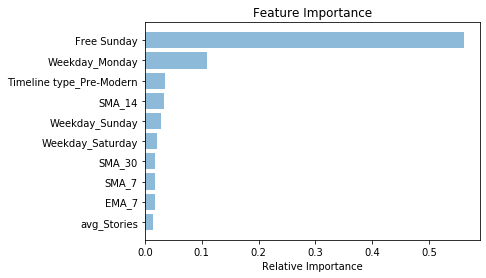

In [94]:
plt.figure()
num_feature = len(feature)
plt.barh(list(np.linspace(0,10-1,10)), feature_importance_10_df["feature_importance"], alpha=0.5)
plt.yticks(list(np.linspace(0,10-1,10)),feature_importance_10_df["feature"])
plt.xlabel("Relative Importance")
plt.title("Feature Importance")
plt.show()

In [95]:
RF_RS_model.feature_importances_

array([5.60512151e-01, 5.88055412e-06, 7.24016125e-03, 8.20094633e-04,
       1.91020272e-03, 5.01620389e-05, 9.92870594e-04, 5.87258512e-05,
       7.12621642e-05, 5.06754833e-04, 0.00000000e+00, 8.60857344e-03,
       1.30045270e-03, 7.49713979e-04, 2.86299381e-04, 5.99791148e-04,
       6.07044486e-04, 6.00607610e-05, 3.02483474e-05, 9.36678898e-06,
       2.08684384e-05, 1.48351286e-03, 1.17236974e-03, 1.33205414e-03,
       1.30580654e-03, 4.34277351e-04, 0.00000000e+00, 3.53752211e-02,
       8.04095947e-04, 9.35777420e-04, 6.17209132e-05, 0.00000000e+00,
       4.72999479e-03, 4.31376435e-03, 0.00000000e+00, 6.16048580e-03,
       5.96639806e-03, 0.00000000e+00, 3.49269651e-03, 1.27487325e-04,
       0.00000000e+00, 1.44476583e-02, 1.15019456e-04, 0.00000000e+00,
       3.95953205e-03, 2.99454492e-03, 0.00000000e+00, 1.86121193e-03,
       1.83810268e-04, 0.00000000e+00, 1.15917883e-02, 5.81487490e-03,
       0.00000000e+00, 1.00776379e-02, 9.59763007e-03, 0.00000000e+00,
      

In [96]:
# Results for Random Searched Random Forest Model
# plt.figure(figsize = (16,8))
# plt.plot(RF_RandomSearch_predict)
# plt.plot(origin_test_y)
# plt.title("Daily Attendance for Museum", fontsize = 16)
# plt.legend(["Predicted_value","Real value"], loc = "upper left")
# plt.ylabel("Daily Attendance",fontsize = 14)
# plt.xlabel("Days",fontsize = 14)
# plt.xticks(np.linspace(1,326,5),pd.DataFrame(Date)["Date"][[int(600+i*325/5) for i in [1,2,3,4,5]]])
# plt.show()
